In [1]:
import tensorflow as tf # Models ran in venv python 3.9.16 with GPU computing support
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import wfdb
import ast
import ecg_plot
print(tf.config.list_physical_devices()) # Verify you have a GPU available. Not required
print(tf.test.is_built_with_cuda())
print(tf.test.is_gpu_available(cuda_only=False, min_cuda_compute_capability=None))

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
True
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
True


In [2]:
sr = 100

In [3]:
with tf.device('/CPU:0'):
    ### Loading raw data into mutable Datframes
    ptb = pd.read_csv('../data/ptbxl_database.csv')
    def load_raw_data(df, sampling_rate, path):
        if(sampling_rate == 100):
            data = [wfdb.rdsamp(path+f) for f in df.filename_lr]
        else:
            data = [wfdb.rdsamp(path+f) for f in df.filename_hr]
        data = np.array([signal for signal, meta in data])
        return data
    
    # load and convert annotation data
    Y = pd.read_csv('../data/ptbxl_database.csv', index_col='ecg_id')
    Y.scp_codes = Y.scp_codes.apply(lambda x: ast.literal_eval(x))

    # Load raw signal data
    X = load_raw_data(Y, sr, '../data/')

    # Load scp_statements.csv for diagnostic aggregation
    agg_df = pd.read_csv('../data/scp_statements.csv', index_col=0)
    agg_df = agg_df[agg_df.diagnostic == 1]

    def aggregate_diagnostic(y_dic):
        tmp = []
        for key in y_dic.keys():
            if key in agg_df.index:
                tmp.append(agg_df.loc[key].diagnostic_class)
        return list(set(tmp))


    # Apply diagnostic superclass
    Y['diagnostic_superclass'] = Y.scp_codes.apply(aggregate_diagnostic)

In [4]:
import numpy as np
from scipy import signal

def normalize(X, shape = False):
    # Compute mean and standard deviation along axis 1 and 2
    X_mean = np.mean(X)
    X_std = np.std(X)

    if(shape):
        print(X.shape)
    # Normalize data by subtracting mean and dividing by standard deviation
    return ((X - X_mean) / X_std)

#____________________________________________________________________________________#

bld = 0.5
def baseline_drift(X, baseline, range = 0):
    bld_range = (baseline-range, baseline+range)
    random_shifts = np.random.uniform(bld_range[0], bld_range[1], size = X.shape)
    return X + random_shifts

#____________________________________________________________________________________#

# Define the filter parameters
fs = 100  # Sampling frequency (Hz)
lowcut = 0.5  # Lower cutoff frequency (Hz)
highcut = 40.0  # Higher cutoff frequency (Hz)
filter_order = 4  # Filter order

def bandpass(X, fs, lowcut, highcut, filter_order):
    # Apply bandpass filter to each channel
    filtered_data = np.zeros_like(X)
    for i in range(X.shape[2]):
        for j in range(X.shape[0]):
            b, a = signal.butter(filter_order, [lowcut, highcut], fs=fs, btype='band', output='ba')
            filtered_data[j, :, i] = signal.filtfilt(b, a, X[j, :, i])

    # Print the shape of the filtered data
    return filtered_data

#____________________________________________________________________________________#

def da_apply(X, functions, shape = False):
    X_final = X.copy()

    # Applys DA Augments in specified order
    for func_dict in functions:
        func = func_dict['func']
        if(func_dict['params'] == None):
            X_final = func(X_final)     
        else:
            params = func_dict['params']
            X_final = func(X_final, *params)  

    if(shape == True):
        print(X_final.shape)

    return X_final

#func_dict = [{'func': normalize, 'params': [None]}]

#func_dict = [{'func': baseline_drift, 'params': [0,0.05]}]

# func_dict =[{'func': normalize, 'params': [None]},
#             {'func': bandpass, 'params': [100, 0.5, 10, 3]}, # 100, 0.5, 10, 3
#             {'func': baseline_drift, 'params': [0,0.075]}]

In [5]:
with tf.device('/CPU:0'):
    func_dict =[{'func': normalize, 'params': [None]},  # Normalizing across the entire data set instead of by lead
                {'func': baseline_drift, 'params': [0,0.075]}]  # I found that simulating a 0.075 drift works best

    X_downsampled = da_apply(X, func_dict) # If you want to experiment with data shape more, use a smaller data size. Subset X

In [6]:
age_model = tf.keras.models.load_model("../saved_models/100hz/age_models/model_1.h5")
sex_model = tf.keras.models.load_model("../saved_models/100hz/sex_models/model_1.h5")

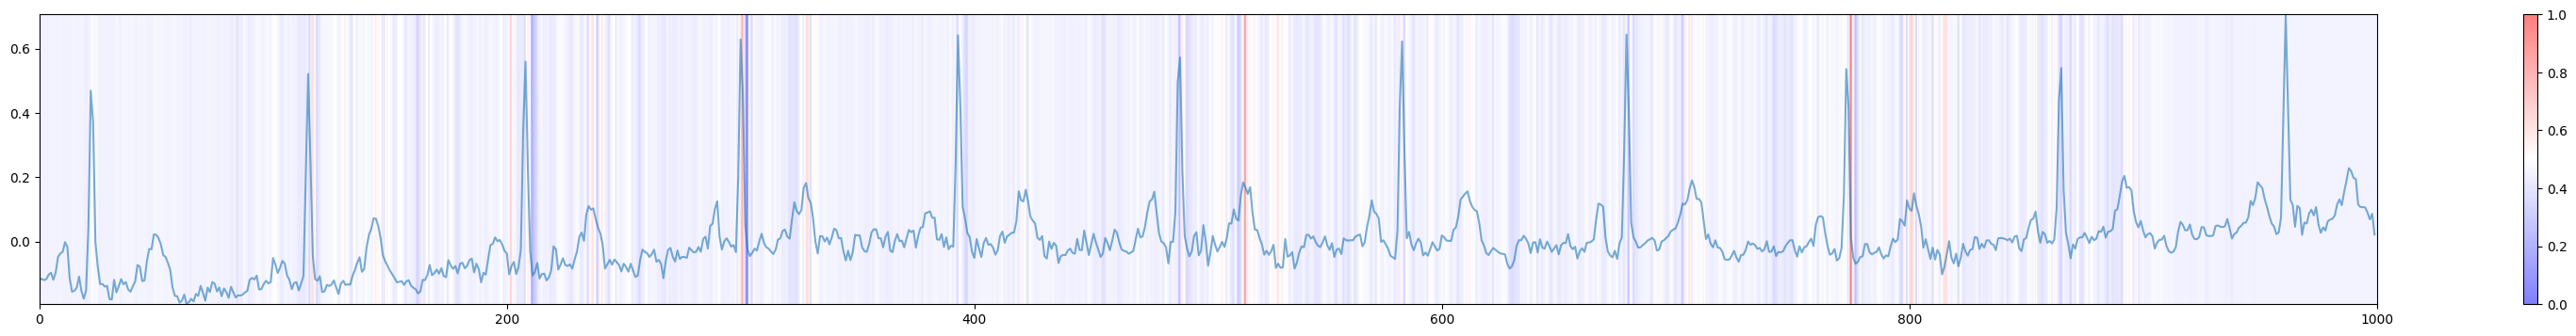

In [7]:
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.collections import LineCollection

sample_index = 0  # Choose the desired sample index
input_data = X_downsampled[sample_index:sample_index + 1]  # Shape: (1, 1000, 12)
input_data_tensor = tf.convert_to_tensor(input_data, dtype=tf.float32)
input_data_tensor.shape

with tf.GradientTape() as tape:
    tape.watch(input_data_tensor)
    predictions = sex_model(input_data_tensor)
    target_class_score = predictions[0, 0]

with tf.device('/CPU:0'):
    gradients = tape.gradient(target_class_score, input_data_tensor)
    weights = tf.reduce_mean(gradients, axis=0)
    heatmap = tf.reduce_sum(input_data_tensor * weights, axis=-1).numpy()
    heatmap_norm = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min())


colors = [(0, 0, 1), (1, 1, 1), (1, 0, 0)]  # Blue, White, Red
custom_cmap = LinearSegmentedColormap.from_list('CustomColormap', colors, N=256)

plt.figure(figsize=(40, 4))
plt.gca().set_aspect(0.001)

plt.plot(X[sample_index, :, 0], alpha = 0.6)
plt.imshow(heatmap_norm[0, :, None].T, cmap=custom_cmap, alpha=0.5, extent=[0, 1000, np.min(X[sample_index, :, 0]), np.max(X[sample_index, :, 0])], aspect='auto')
plt.colorbar()
plt.show()

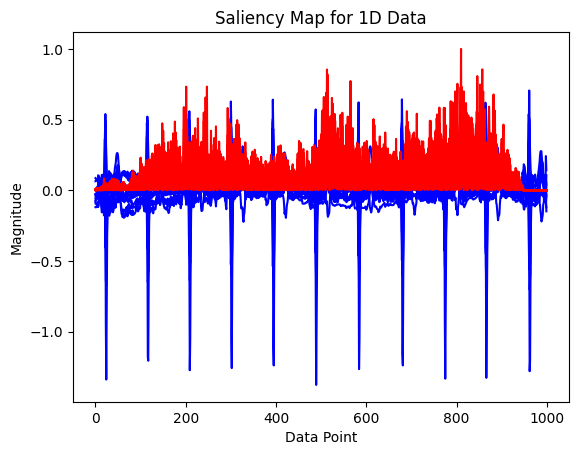

In [8]:
saliency_map = np.abs(gradients)
saliency_map = (saliency_map - np.min(saliency_map)) / (np.max(saliency_map) - np.min(saliency_map))

# Plot the saliency map
plt.plot(X[0], color='blue', label='Data')
plt.plot(saliency_map[0], color='red', label='Saliency Map')
plt.xlabel('Data Point')
plt.ylabel('Magnitude')
plt.title('Saliency Map for 1D Data')
plt.show()

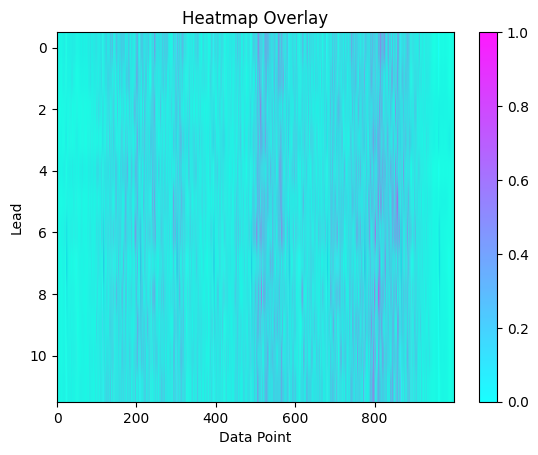

In [9]:
plt.imshow(X[0].T, cmap='hot', aspect='auto')
plt.imshow(saliency_map[0].T, cmap='cool', alpha=0.9, aspect='auto')
plt.colorbar()
plt.xlabel('Data Point')
plt.ylabel('Lead')
plt.title('Heatmap Overlay')
plt.show()


### Meshgrid test

C:\Users\varun\AppData\Local\Temp\ipykernel_10292\716574131.py:40: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = plt.scatter(np.arange(len(input_data[sample, :, lead])), input_data[sample, :, lead], c=colors[:, lead, :], cmap=ccol, marker='o', s=dot_size, alpha=1)
C:\Users\varun\AppData\Local\Temp\ipykernel_10292\716574131.py:57: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm, orientation = 'horizontal')


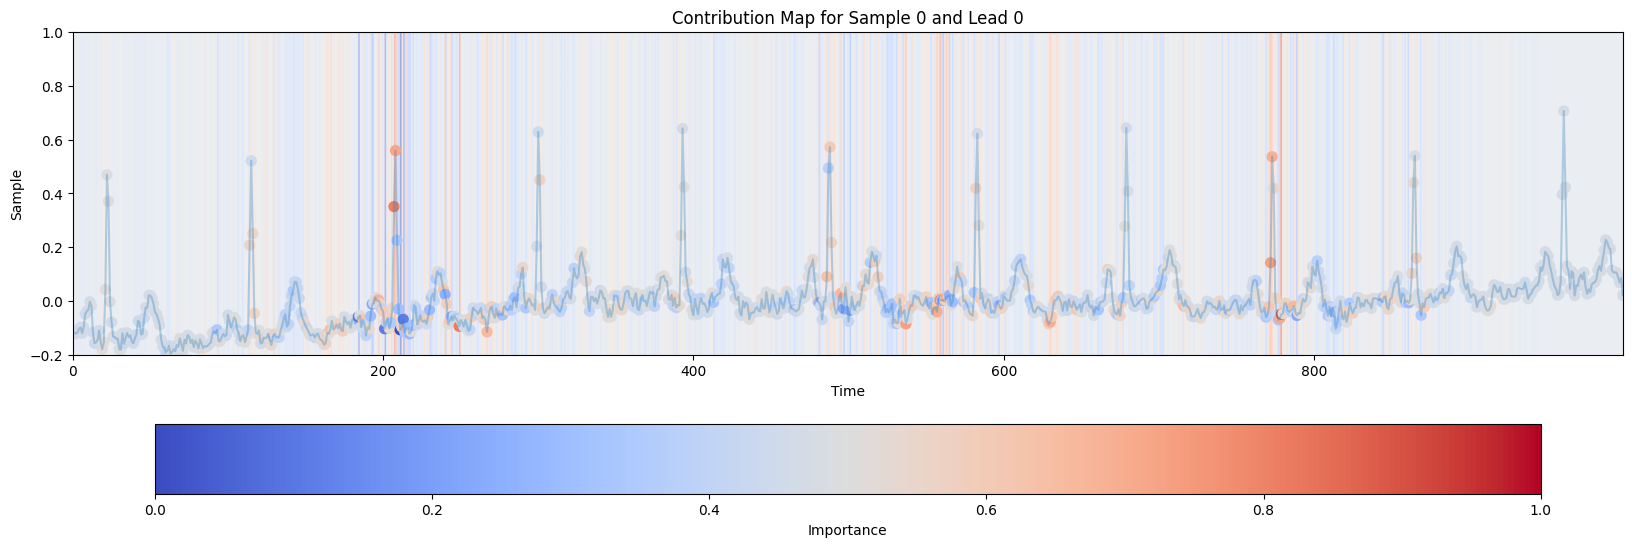

In [212]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy import interpolate



# Define the Grad-CAM function
def grad_cam(model, input_data, target_class):
    # Convert the input_data to a TensorFlow tensor
    input_data = tf.convert_to_tensor(input_data, dtype=tf.float32)

    # Record operations for gradient calculation
    input_data = tf.Variable(input_data, trainable=True)

    # Forward pass
    with tf.GradientTape() as tape:
        predictions = model(input_data)
        target_score = predictions[:, target_class]

    # Calculate gradients of the target score with respect to the input_data
    gradients = tape.gradient(target_score, input_data)

    # Calculate the importance scores
    importance_scores = tf.reduce_mean(gradients, axis=0).numpy()

    return importance_scores


def visualize_importance(model, input_data, target_class, sample, lead, heatmap, ccol = 'coolwarm', dot_size = 7,fsize = (20, 6)):
    importance_scores = grad_cam(model, np.expand_dims(input_data[sample, :, :], axis=0), target_class)
    normalized_importance_scores = (importance_scores - np.min(importance_scores)) / (np.max(importance_scores) - np.min(importance_scores))
    cmap = plt.get_cmap(ccol)
    colors = cmap(normalized_importance_scores)
    colors_lead = np.squeeze(colors[:,lead,:])

    plt.figure(figsize=fsize)
    plt.plot(input_data[sample, :, lead], alpha=0.3)
    scatter = plt.scatter(np.arange(len(input_data[sample, :, lead])), input_data[sample, :, lead], c=colors[:, lead, :], cmap=ccol, marker='o', s=dot_size, alpha=1)

    # Create a time array for x-axis
    time_axis = np.arange(input_data.shape[1])


    color_matrix = np.tile(np.expand_dims(colors_lead, axis=0), (input_data.shape[1], 1, 1))


    # Plot the heatmap using imshow
    if(heatmap == True):
        plt.imshow(color_matrix, cmap=ccol, alpha=0.5, aspect='auto', extent=[time_axis[0], time_axis[-1], -0.2, 1])


    # Add color bar with 'coolwarm' colormap
    sm = cm.ScalarMappable(cmap=cmap)
    sm.set_array([])  # Important for the color bar to show the correct range of colors
    cbar = plt.colorbar(sm, orientation = 'horizontal')
    cbar.set_label('Importance')


    # Add labels and title
    plt.xlabel('Time')
    plt.ylabel('Sample')
    plt.title(f'Contribution Map for Sample {sample} and Lead {lead}')

    # Show the plot
    plt.show()


visualize_importance(sex_model, X, 0, 0, 0, True, 'coolwarm', 50)

C:\Users\varun\AppData\Local\Temp\ipykernel_10292\1940301548.py:7: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(np.arange(len(ecg_signal)), ecg_signal[:,0], c=colors[:,0,:], cmap='coolwarm', marker='o', s=15, alpha = 1)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


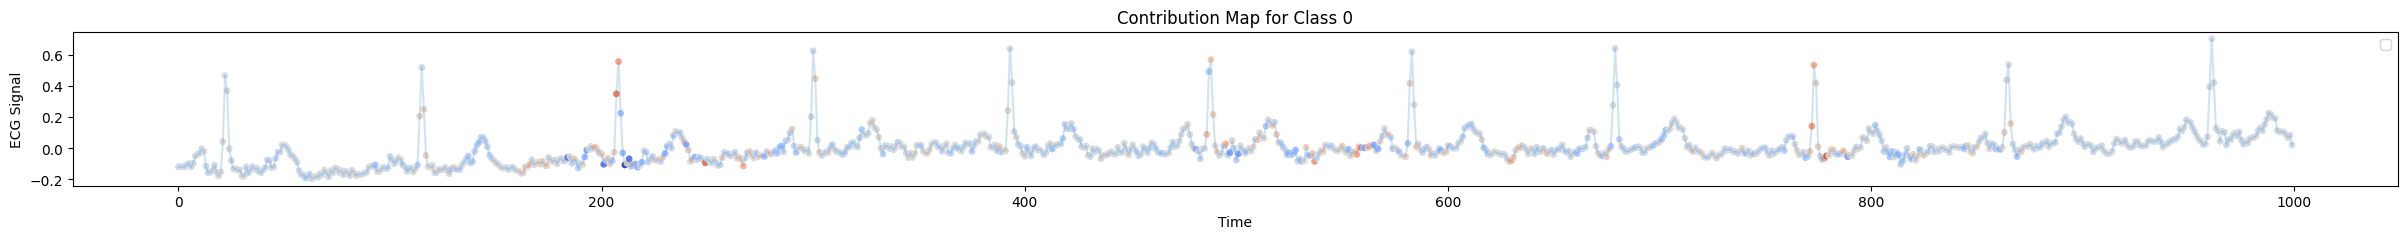

In [111]:

# Plot the ECG signal
plt.figure(figsize=(30, 2))


# Plot the contribution map as a scatter plot with colors based on the importance scores
plt.plot(ecg_signal[:,0], alpha = 0.2)
plt.scatter(np.arange(len(ecg_signal)), ecg_signal[:,0], c=colors[:,0,:], cmap='coolwarm', marker='o', s=15, alpha = 1)

# Add color bar


# Add labels, legend, and show the plot
plt.xlabel('Time')
plt.ylabel('ECG Signal')
plt.title(f'Contribution Map for Class {target_class}')
plt.legend()
plt.show()

In [112]:
colors.shape

(1000, 12, 4)

In [114]:
(ecg_signal[0]).shape

(12,)

In [115]:
X[0, :, 0].shape

(1000,)